**Introduction**

This final project explores the best locations for opening an Italian restaurant in Brooklyn, New York. New York is the most densely populated and is a major city 
in the United States. New York City is composed of 5 boroughs and they are Brooklyn, Queens, Manhattan, Bronx, and Staten Island. Of these 5 boroughs, 
Brooklyn is the largest borough by population. New York has the largest population of Italians at 3.1 million people. People migrated from many parts of the world. 
There are many restaurants in New York City with different cuisines such as American, Italian, Chinese, Indian etc. Here the audience can be anyone who is looking to open or invest in a restaurant.

**Data**

For this project we need the following data: 
1. New York City dataset that contains Borough, Neighborhoods along with their latitudes and longitudes    
Data Source: https://cocl.us/new_york_datase      
Description: This dataset contains the required information. And we will use this dataset to explore various neighborhoods of New York City.

2. Italian restaurants in Brooklyn neighborhood of New York City       
Data Source: Foursquare API 
Description: By using this API we will get all the venues in the Brooklyn neighborhood. We can filter these venues to get only Italian restaurants.

**Approach**
1. Collect the New York City data from the above-mentioned dataset.

2. We will get all the venues present in the Brooklyn Neighborhood using the Foursquare API.

3. Filter out all the venues that are Italian restaurants.

4. Analyzing the data using Kmeans Clustering and visualizing the neighborhoods with the number of Italian restaurants present.

5. In the end, compare these neighborhoods to find the best possible location for opening up an Italian restaurant.

**Problem Statement**
1. What will be the best location for an Italian restaurant in Brooklyn, NY?
2. Which neighborhood is the best for one who is looking out to open an Italian restaurant in Brooklyn, NY?

Importing all the required libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Collecting the New York City data

In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Getting the required columns and adding each row into the dataframe using for loop

In [6]:
neighborhoods

for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Filtering the data to get only the neighborhoods present in Brooklyn

In [9]:
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Brooklyn,Bay Ridge,40.625801,-74.030621
1,Brooklyn,Bensonhurst,40.611009,-73.995180
2,Brooklyn,Sunset Park,40.645103,-74.010316
3,Brooklyn,Greenpoint,40.730201,-73.954241
4,Brooklyn,Gravesend,40.595260,-73.973471


Using geocoder to get the coordinates of "Brooklyn, NY"

In [10]:
address = 'Brooklyn, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn are 40.6501038, -73.9495823.


In [11]:
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Borough'], brooklyn_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

Define Foursquare API credentials

In [12]:
CLIENT_ID = 'KYCIDFNOHWQ4XOBTHTMFL4JW4Q0MFUEZOYHNEB3DS2WA5NP1' # your Foursquare ID
CLIENT_SECRET = 'AZ001CY00LFU3SPIPRRME1V4IEF2YNPDLUZEV0AWIAJVVVSG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
ACCESS_TOKEN = 'B3FMQX1FZYF3SGVIA2G4HHHSCQU5GYKD0DQVFWFP1VCXVRYN'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KYCIDFNOHWQ4XOBTHTMFL4JW4Q0MFUEZOYHNEB3DS2WA5NP1
CLIENT_SECRET:AZ001CY00LFU3SPIPRRME1V4IEF2YNPDLUZEV0AWIAJVVVSG


In [13]:
brooklyn_data.loc[0, 'Neighborhood']

'Bay Ridge'

In [14]:
neighborhood_latitude = brooklyn_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = brooklyn_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = brooklyn_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Bay Ridge are 40.625801065010656, -74.03062069353813.


In [15]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=KYCIDFNOHWQ4XOBTHTMFL4JW4Q0MFUEZOYHNEB3DS2WA5NP1&client_secret=AZ001CY00LFU3SPIPRRME1V4IEF2YNPDLUZEV0AWIAJVVVSG&v=20180605&ll=40.625801065010656,-74.03062069353813&radius=500&limit=100'

In [16]:
results = requests.get(url).json()

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Categorizing the data to get the required Venue details such as Venue name, Latitude, Longitude, and the category it belongs to

In [18]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Pilo Arts Day Spa and Salon,Spa,40.624748,-74.030591
1,Bagel Boy,Bagel Shop,40.627896,-74.029335
2,Leo's Casa Calamari,Pizza Place,40.624200,-74.030931
3,Cocoa Grinder,Juice Bar,40.623967,-74.030863
4,Pegasus Cafe,Breakfast Spot,40.623168,-74.031186


In [19]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

81 venues were returned by Foursquare.


Function to get nearby venues of all the neighborhoods

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    LIMIT=100
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Using the above function to get all the venues present in Brooklyn

In [21]:
brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )

Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker Heights
Gerritsen Beach
Marine Park
Clinton Hill
Sea Gate
Downtown
Boerum Hill
Prospect Lefferts Gardens
Ocean Hill
City Line
Bergen Beach
Midwood
Prospect Park South
Georgetown
East Williamsburg
North Side
South Side
Ocean Parkway
Fort Hamilton
Ditmas Park
Wingate
Rugby
Remsen Village
New Lots
Paerdegat Basin
Mill Basin
Fulton Ferry
Vinegar Hill
Weeksville
Broadway Junction
Dumbo
Homecrest
Highland Park
Madison
Erasmus


In [22]:
print(brooklyn_venues.shape)
brooklyn_venues.head()

(2724, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bay Ridge,40.625801,-74.030621,Pilo Arts Day Spa and Salon,40.624748,-74.030591,Spa
1,Bay Ridge,40.625801,-74.030621,Bagel Boy,40.627896,-74.029335,Bagel Shop
2,Bay Ridge,40.625801,-74.030621,Leo's Casa Calamari,40.624200,-74.030931,Pizza Place
3,Bay Ridge,40.625801,-74.030621,Cocoa Grinder,40.623967,-74.030863,Juice Bar
4,Bay Ridge,40.625801,-74.030621,Pegasus Cafe,40.623168,-74.031186,Breakfast Spot


In [23]:
brooklyn_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bath Beach,48,48,48,48,48,48
Bay Ridge,81,81,81,81,81,81
Bedford Stuyvesant,30,30,30,30,30,30
Bensonhurst,32,32,32,32,32,32
Bergen Beach,8,8,8,8,8,8
Boerum Hill,88,88,88,88,88,88
Borough Park,23,23,23,23,23,23
Brighton Beach,43,43,43,43,43,43
Broadway Junction,19,19,19,19,19,19


In [24]:
print('There are {} uniques categories.'.format(len(brooklyn_venues['Venue Category'].unique())))

There are 288 uniques categories.


Performing the hot encoding to get the dummies

In [25]:
# one hot encoding
brooklyn_onehot = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_onehot['Neighborhood'] = brooklyn_venues['Neighborhood'] 

brooklyn_onehot.set_index('Neighborhood', inplace=True)


In [26]:
brooklyn_onehot.reset_index(inplace=True)

In [27]:
brooklyn_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Gym,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookst

In [28]:
brooklyn_onehot.shape

(2724, 288)

In [29]:
brooklyn_grouped = brooklyn_onehot.groupby('Neighborhood').mean().reset_index()
brooklyn_grouped

,Neighborhood,Accessories Store,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hockey Field,Home Service,Hookah Bar,Hostel,Hotel,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Gym,Outdoors & Recreation,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Piercing Parlor,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Club,Roller Rink,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toy / Game Store,Trail,Turkish Restaurant,Used Bookst

In [30]:
brooklyn_grouped.shape

(70, 288)

Displaying the mean frequency of each venue located in their respective neighborhood

In [31]:
num_top_venues = 5

for hood in brooklyn_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = brooklyn_grouped[brooklyn_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bath Beach----
                  venue  freq
0    Chinese Restaurant  0.08
1       Bubble Tea Shop  0.06
2           Pizza Place  0.04
3  Cantonese Restaurant  0.04
4    Italian Restaurant  0.04


----Bay Ridge----
                 venue  freq
0                  Spa  0.06
1   Italian Restaurant  0.06
2          Pizza Place  0.05
3           Bagel Shop  0.05
4  American Restaurant  0.04


----Bedford Stuyvesant----
           venue  freq
0    Coffee Shop  0.10
1  Deli / Bodega  0.10
2    Pizza Place  0.07
3           Café  0.07
4            Bar  0.07


----Bensonhurst----
                venue  freq
0  Chinese Restaurant  0.09
1      Ice Cream Shop  0.06
2    Sushi Restaurant  0.06
3          Donut Shop  0.06
4  Italian Restaurant  0.06


----Bergen Beach----
             venue  freq
0  Harbor / Marina  0.25
1             Park  0.25
2     Hockey Field  0.12
3   Baseball Field  0.12
4       Playground  0.12


----Boerum Hill----
                 venue  freq
0          Coffee Shop  0.

Extracting the Neighborhood and the Italian restaurant columns for further analysis

In [32]:
brooklyn_grouped_italian = brooklyn_grouped[['Neighborhood', 'Italian Restaurant']]
brooklyn_grouped_italian

,Neighborhood,Italian Restaurant
0,Bath Beach,0.041667
1,Bay Ridge,0.061728
2,Bedford Stuyvesant,0.033333
3,Bensonhurst,0.062500
4,Bergen Beach,0.000000
5,Boerum Hill,0.011364
6,Borough Park,0.000000
7,Brighton Beach,0.000000
8,Broadway Junction,0.000000
9,Brooklyn Heights,0.040000


In [33]:
brooklyn_grouped_clustering = brooklyn_grouped_italian.drop('Neighborhood', 1)
brooklyn_grouped_clustering

,Italian Restaurant
0,0.041667
1,0.061728
2,0.033333
3,0.062500
4,0.000000
5,0.011364
6,0.000000
7,0.000000
8,0.000000
9,0.040000


Getting the best value of K using the KMeans (Elbow method)

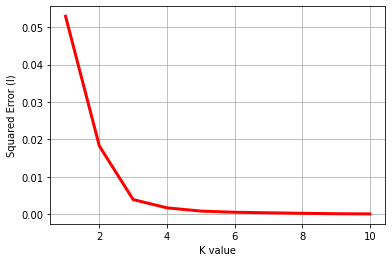

In [34]:
l = []
for i in range(1, 11):
  k = KMeans(n_clusters = i, max_iter = 500)
  k.fit(brooklyn_grouped_clustering)
  l.append(k.inertia_)

plt.plot(range(1, 11), l, color = 'r', linewidth = '3')
plt.xlabel("K value")
plt.ylabel("Squared Error (l)")
plt.grid()
plt.show()

From the above graph, it is clear that the best value of k is 3 and so we'll be clustering the neighborhoods of Brooklyn into 3 different clusters say Cluster 0 ,1, and 2.

In [36]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(brooklyn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:5]

array([2, 2, 2, 2, 0], dtype=int32)

In [37]:
# add clustering labels
brooklyn_data.insert(0, 'Cluster Labels', kmeans.labels_)

brooklyn_merged = brooklyn_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
brooklyn_merged = brooklyn_grouped_italian.join(brooklyn_merged.set_index('Neighborhood'), on='Neighborhood')

brooklyn_merged.head() # check the last columns!

,Neighborhood,Italian Restaurant,Cluster Labels,Borough,Latitude,Longitude
0,Bath Beach,0.041667,2,Brooklyn,40.599519,-73.998752
1,Bay Ridge,0.061728,2,Brooklyn,40.625801,-74.030621
2,Bedford Stuyvesant,0.033333,0,Brooklyn,40.687232,-73.941785
3,Bensonhurst,0.062500,2,Brooklyn,40.611009,-73.995180
4,Bergen Beach,0.000000,0,Brooklyn,40.615150,-73.898556


In [38]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(brooklyn_merged['Latitude'], brooklyn_merged['Longitude'], brooklyn_merged['Neighborhood'], brooklyn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now that we've produced a map for the 3 clusters. Let's examine each and every cluster.

In [39]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 0] # Cluster 0

,Neighborhood,Italian Restaurant,Cluster Labels,Borough,Latitude,Longitude
2,Bedford Stuyvesant,0.033333,0,Brooklyn,40.687232,-73.941785
4,Bergen Beach,0.000000,0,Brooklyn,40.615150,-73.898556
6,Borough Park,0.000000,0,Brooklyn,40.633131,-73.990498
7,Brighton Beach,0.000000,0,Brooklyn,40.576825,-73.965094
9,Brooklyn Heights,0.040000,0,Brooklyn,40.695864,-73.993782
10,Brownsville,0.000000,0,Brooklyn,40.663950,-73.910235
12,Canarsie,0.000000,0,Brooklyn,40.635564,-73.902093
13,Carroll Gardens,0.110000,0,Brooklyn,40.680540,-73.994654
14,City Line,0.000000,0,Brooklyn,40.678570,-73.867976
15,Clinton Hill,0.050000,0,Brooklyn,40.693229,-73.967843


In [40]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 1] # Cluster 1

,Neighborhood,Italian Restaurant,Cluster Labels,Borough,Latitude,Longitude
5,Boerum Hill,0.011364,1,Brooklyn,40.685683,-73.983748
34,Gerritsen Beach,0.000000,1,Brooklyn,40.590848,-73.930102
54,Prospect Heights,0.000000,1,Brooklyn,40.676822,-73.964859


In [41]:
brooklyn_merged.loc[brooklyn_merged['Cluster Labels'] == 2] # Cluster 2

,Neighborhood,Italian Restaurant,Cluster Labels,Borough,Latitude,Longitude
0,Bath Beach,0.041667,2,Brooklyn,40.599519,-73.998752
1,Bay Ridge,0.061728,2,Brooklyn,40.625801,-74.030621
3,Bensonhurst,0.062500,2,Brooklyn,40.611009,-73.995180
8,Broadway Junction,0.000000,2,Brooklyn,40.677861,-73.903317
11,Bushwick,0.013699,2,Brooklyn,40.698116,-73.925258
18,Crown Heights,0.000000,2,Brooklyn,40.670829,-73.943291
23,Dyker Heights,0.000000,2,Brooklyn,40.619219,-74.019314
31,Fort Hamilton,0.049180,2,Brooklyn,40.614768,-74.031979
32,Fulton Ferry,0.017544,2,Brooklyn,40.703281,-73.995508
35,Gowanus,0.050000,2,Brooklyn,40.673931,-73.994441


Visualizing the number of Italian restaurants in each neighborhood of Brooklyn in the form of a bar graph.

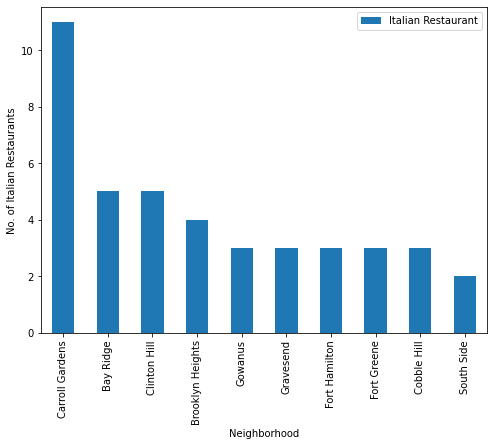

In [42]:
graph = pd.DataFrame(brooklyn_onehot.groupby('Neighborhood')['Italian Restaurant'].sum())
graph = graph.sort_values(by = 'Italian Restaurant', ascending = False)
graph.iloc[:10].plot(kind = 'bar', figsize = (8,6))
plt.xlabel('Neighborhood')
plt.ylabel('No. of Italian Restaurants')
plt.show()

**Results**
1. Carroll Gardens neighborhood has the highest number of Italian restaurants.
2. Bay Ridge neighborhood has a high density of Italian restaurants.
3. I will open the restaurant in Gerriston Beach.

According to the analysis, Gerriston Beach will provide the least competition for an upcoming Italian restaurant as there is a shopping mall close to this neighborhood. And, it's going to be a beachside restaurant where people would like to explore, try something new, and would like to have more options handy. So, all this is the best place for all of those who are interested in getting a taste of the Italian Cuisine and also, the frequency of Italian restaurants is very low compared to the other neighborhoods. Carroll Gardens has the highest number of Italian restaurants and Bay Ridge is highly dense so, we will not open there. The analysis I did is completely relied on the data provided by Foursquare API and using KMeans clustering. There are a number of factors such as the number of customers, land value, distance that play a major role in stating that this analysis is far from being conclusory. However, it definitely gives us some very important preliminary information on the possibilities of opening restaurants in the Brooklyn borough of New York City. And, the results might vary if we had used some other clustering techniques like DBSCAN.


**Conclusion**

Finally, to conclude this project, we have got a small glimpse of how a real-life Data science project looks like. I have used some frequently used python libraries to handle loading the JSON file, plotting graphs, and performing other exploratory data analysis. Used Foursquare API to major boroughs of New York City and their neighborhoods. Potential for this kind of analysis in a real-life business problem is discussed in great detail. As a final note, all of the above analyses is based on the FourSquare data. A more comprehensive analysis and future work would need to incorporate data from other external resources.